# DICOM loading and visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from my_utils import *

---

## Load images

We load the images using the `pydicom.dcmread` function. Since each file is a slice of the volumetric image, we return a list of sorted slices by `SliceLocation` attribute. That attribute give us the location of the slice, which can be used to sort the frames.

In [3]:
REFERENCE_IMAGE_FOLDER = '../data/31_EQP_Ax5.00mm/'
TARGET_IMAGE_FOLDER = '../data/10_AP_Ax5.00mm/'
TUMOR_IMAGE_FILE = '../data/31_EQP_Ax5.00mm_ManualROI_Tumor.dcm'
LIVER_IMAGE_FILE = '../data/31_EQP_Ax5.00mm_ManualROI_Liver.dcm'

In [4]:
reference_img = load_image(REFERENCE_IMAGE_FOLDER)
target_img = load_image(TARGET_IMAGE_FOLDER)

## Acquisition Number

We should also check the acquisition number (`AcquisitionNumber`) of both reference and target images. If the acquisition number is the same in all the reference images it means that all the slices where taken at the same time. If they are different it means that there are mixed different scans and we should split them to properly visualize each of the acquisitions.

In [5]:
assert_acquisition_number(reference_img)
assert_acquisition_number(target_img)

Same acquisition number
Same acquisition number


We have asserted that they have the same acquisition number, so we don't need to split them.

## Slice Thickness and Pixel Spacing

Other important DICOM headers are the slice thickness (`SliceThickness`) and pixel spacing (`PixelSpacing`).

Slice thickness refers to the size of each image slice (z-axis).

Pixel spacing refers to the spaceing between pixels along the x and y axis.

In [6]:
assert_geometric_properties(reference_img)
assert_geometric_properties(target_img)

Different slice thickness
Same pixel spacing at x-axis
Same pixel spacing at y-axis
Different slice thickness
Same pixel spacing at x-axis
Same pixel spacing at y-axis


Here we can see that there are different slice thickness for the reference and target images. It may happen that the last slice introduce some metadata over all the acquisition and it may introduce noise if we don't remove it before the visualization.

In [7]:
reference_img = reference_img[:-1]
target_img = target_img[:-1]

In [8]:
assert_geometric_properties(reference_img)
assert_geometric_properties(target_img)

Same slice thickness
Same pixel spacing at x-axis
Same pixel spacing at y-axis
Same slice thickness
Same pixel spacing at x-axis
Same pixel spacing at y-axis


In [9]:
print_geometric_properties(reference_img)
print_geometric_properties(target_img)

Pixel Spacing, x-axis:   0.798828
Pixel Spacing, y-axis:   0.798828
Slice Thickness, z-axis: 5.000000
Slice Increment: {5.0}
3D volume (x, y, z) in mm: 408.999936 408.999936 265.0
Pixel Spacing, x-axis:   0.798828
Pixel Spacing, y-axis:   0.798828
Slice Thickness, z-axis: 5.000000
Slice Increment: {5.0}
3D volume (x, y, z) in mm: 408.999936 408.999936 265.0


From the slice thickness, pixel spacing, length of slice list, slice shape and patient position, we are able to compute the size of the 3D image.

In [10]:
reference_img = reference_img[::-1]
target_img = target_img[::-1]

## Visualization

Once we have explored the image headers, we are ready to visualize them.

First, we are going to visualize the images without segmentation from different planes:
- Axial
- Coronal
- Saggital

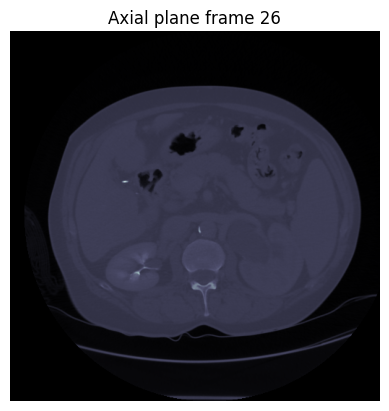

Animation saved on ../results/reference_axial_plane.gif


In [11]:
make_axial_plane_gif(reference_img, "reference_axial_plane.gif", "../results/")

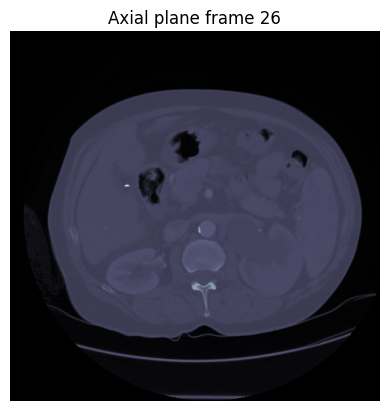

Animation saved on ../results/target_axial_plane.gif


In [12]:
make_axial_plane_gif(target_img, "target_axial_plane.gif", "../results/")

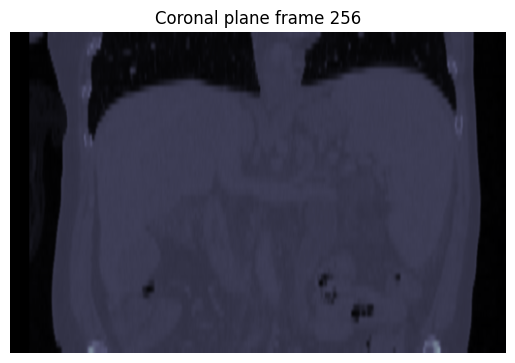

Animation saved on ../results/reference_coronal_plane.gif


In [13]:
make_coronal_plane_gif(reference_img, "reference_coronal_plane.gif")

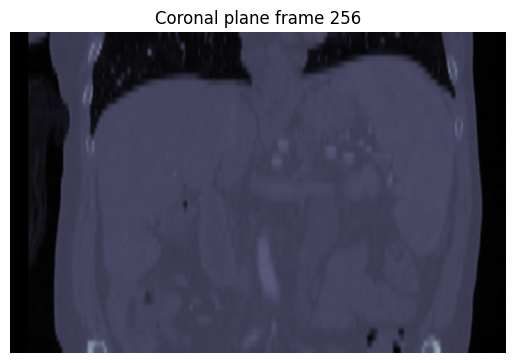

Animation saved on ../results/target_coronal_plane.gif


In [14]:
make_coronal_plane_gif(target_img, "target_coronal_plane.gif")

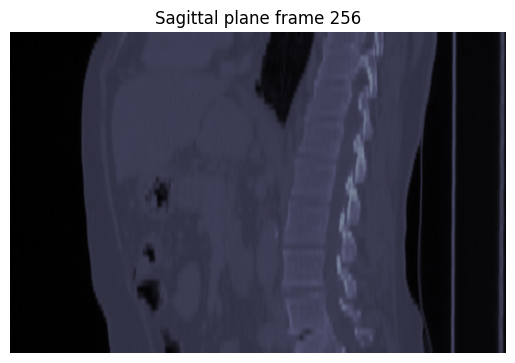

Animation saved on ../results/reference_sattigal_plane.gif


In [15]:
make_saggital_plane_gif(reference_img, "reference_sattigal_plane.gif")

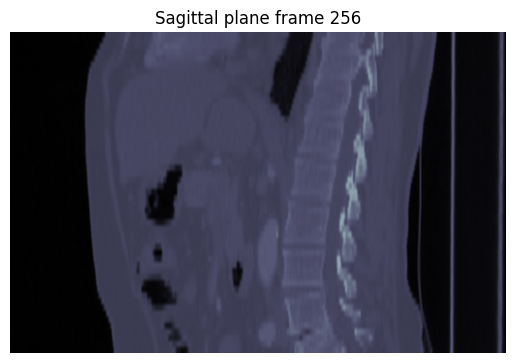

Animation saved on ../results/target_sagittal_plane.gif


In [16]:
make_saggital_plane_gif(target_img, "target_sagittal_plane.gif")

These animations use the adaptative min/max values in combination of bone cmap to plot the planes.

We can use some function to improve the visualization like: median, maximum intensity projection and average intensity projection.

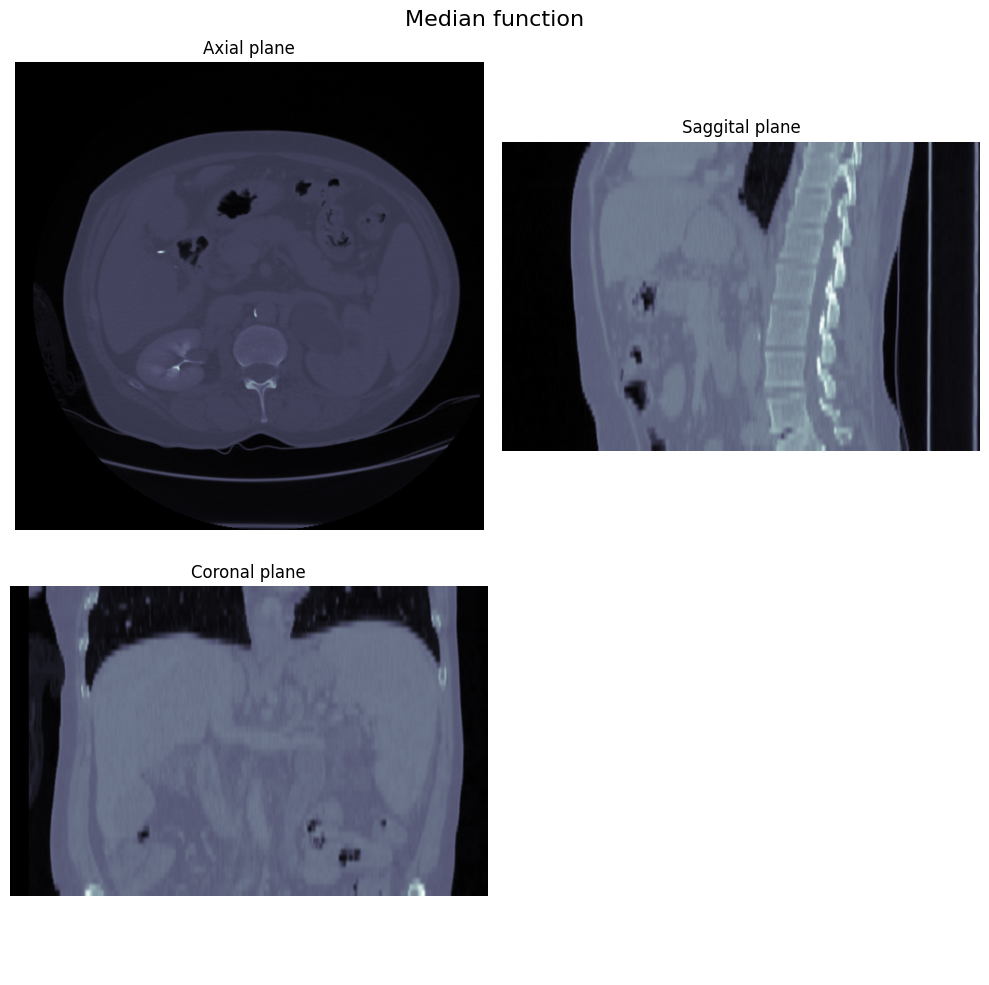

In [17]:
plot_planes(
    reference_img,
    median_axial_plane,
    median_coronal_plane,
    median_sagittal_plane,
    "Median function")

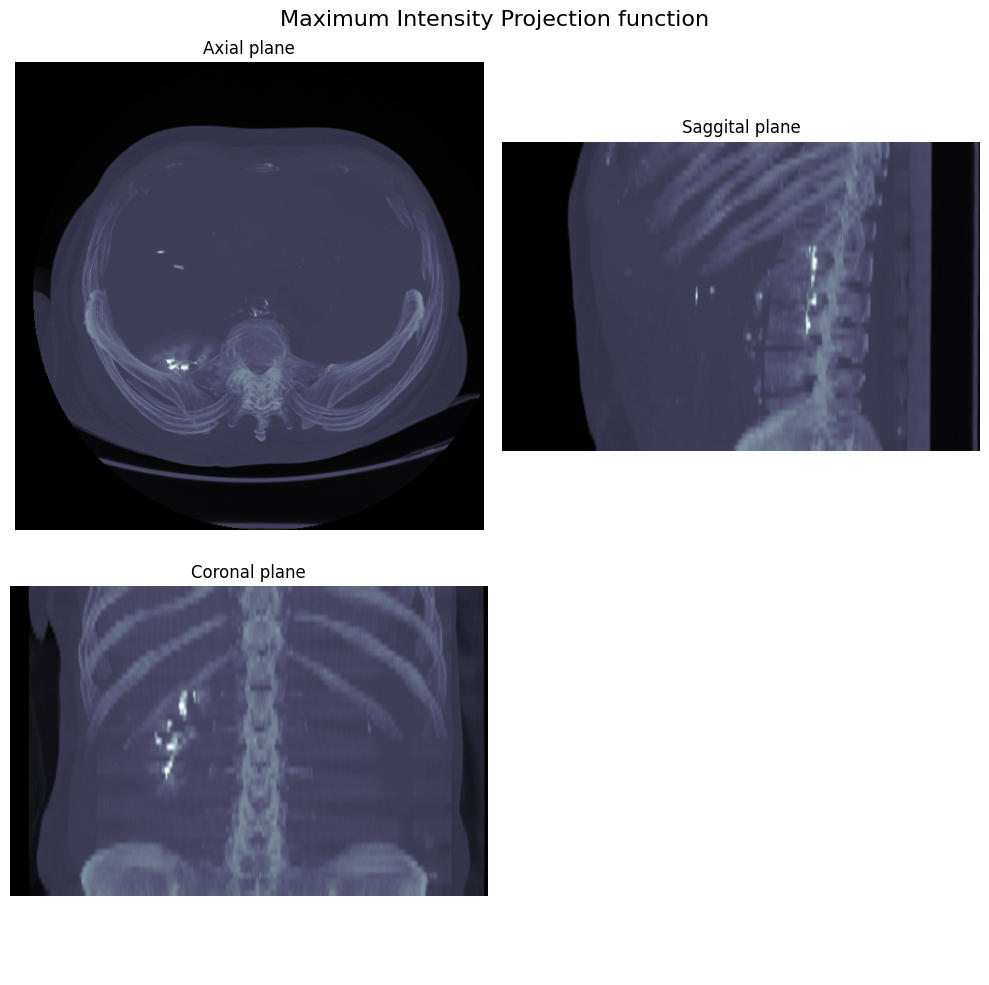

In [18]:
plot_planes(
    reference_img,
    MIP_axial_plane,
    MIP_coronal_plane,
    MIP_sagittal_plane,
    "Maximum Intensity Projection function")

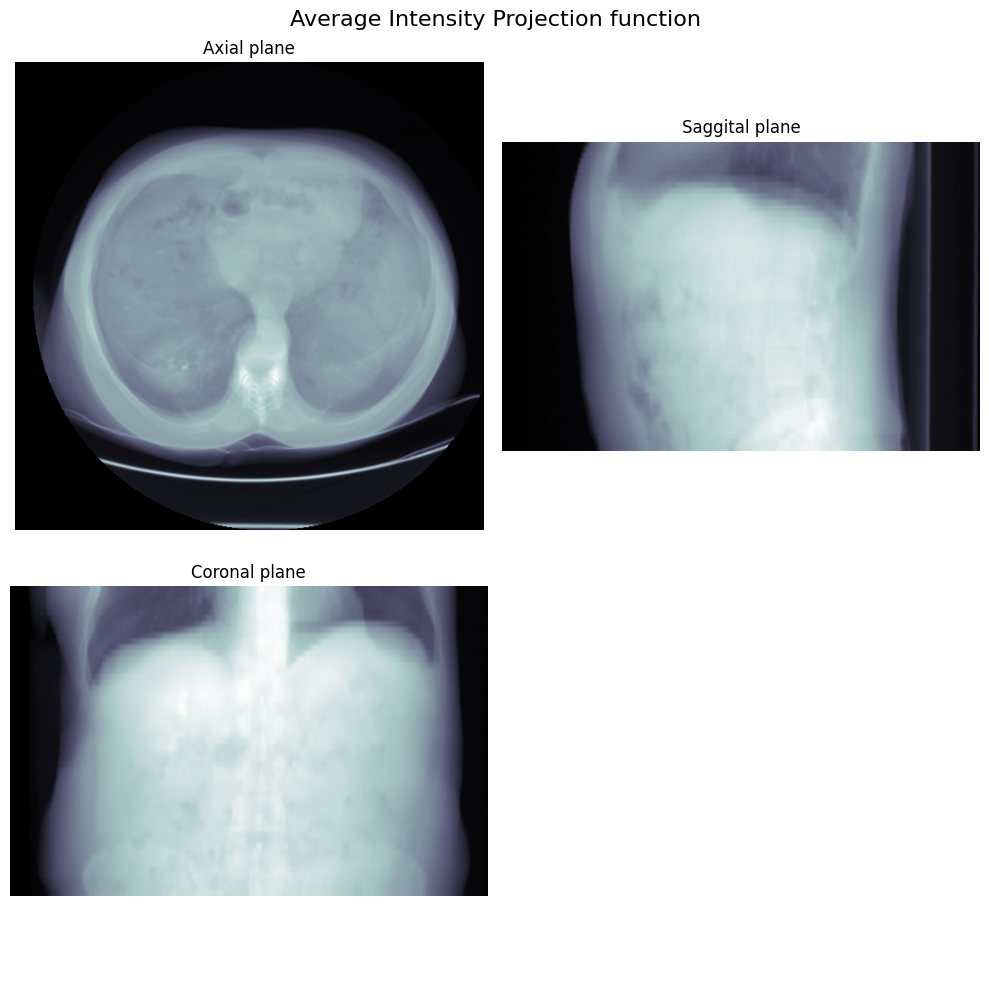

In [19]:
plot_planes(
    reference_img,
    AIP_axial_plane,
    AIP_coronal_plane,
    AIP_sagittal_plane,
    "Average Intensity Projection function")

As we can see, from these functions the MIP is the one which allow us to see better the differences in the image. We are will use this function for the Sagittal-Coronal rotation animation.

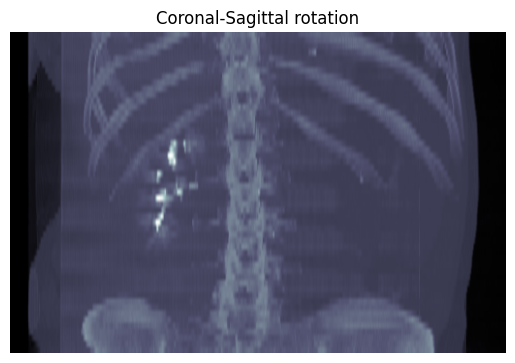

Animation saved on ../results/MIP/reference_coronal-sagittal_rotation.png


In [20]:
coronal_sagittal_rotation(reference_img, "reference_coronal-sagittal_rotation.png")

This visualization of the Coronal-Saggital planes allow us to see from different angles.

## Segmentation file

Now, we will include the tumor and the liver in the visualization in order to include them into each plane and Coronal-Sagittal rotation plane.

In [21]:
len(reference_img)

53

In [22]:
tumor_img = pydicom.dcmread(TUMOR_IMAGE_FILE)
tumor_img.pixel_array.shape

(11, 512, 512)

The tumor segmentation have 11 slices of 53 from the reference image. We can use the Image Position Patient to ensure that we are matching the right reference index with the tumor slice.

In [23]:
tumor_mask = np.zeros_like(np.array([item.pixel_array for item in reference_img]))
tumor_mask.shape

(53, 512, 512)

In [24]:
def find_index(target):
    for i, frame in enumerate(reference_img):
        if frame.ImagePositionPatient[2] == target:
            return i
    return None

In [25]:
for i, frame in enumerate(tumor_img.PerFrameFunctionalGroupsSequence):
    position_patient = frame.PlanePositionSequence[0].ImagePositionPatient[2]  # get z
    # search position patient index
    idx = find_index(position_patient)
    if idx is None:
        print("Can't find matching position patient", position_patient)
    tumor_mask[idx] = tumor_img.pixel_array[i]

Same as we did with the tumor, we need to load the liver and match the frames from the segmentation with the frame of the reference.

In [26]:
liver_img = pydicom.dcmread(LIVER_IMAGE_FILE)
liver_img.pixel_array.shape

(37, 512, 512)

In [27]:
liver_mask = np.zeros_like(np.array([item.pixel_array for item in reference_img]))
liver_mask.shape

(53, 512, 512)

In [28]:
for i, frame in enumerate(liver_img.PerFrameFunctionalGroupsSequence):
    position_patient = frame.PlanePositionSequence[0].ImagePositionPatient[2]  # get z
    # search position patient index
    idx = find_index(position_patient)
    if idx is None:
        print("Can't find matching position patient", position_patient)
    liver_mask[idx] = liver_img.pixel_array[i]

### Segmentation visualization

Now that we a 3D array with the same shape that the reference image, we can show both at the same time.

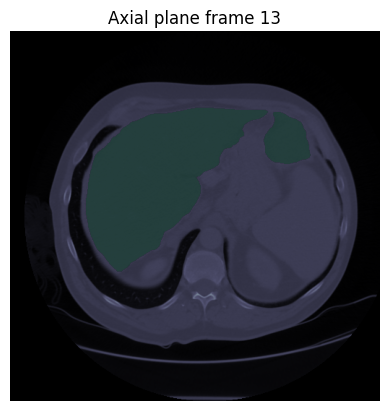

Animation saved on ../results/reference_axial_plane_seg.gif


In [29]:
make_axial_plane_with_seg_gif(reference_img, tumor_mask, liver_mask, "reference_axial_plane_seg.gif")

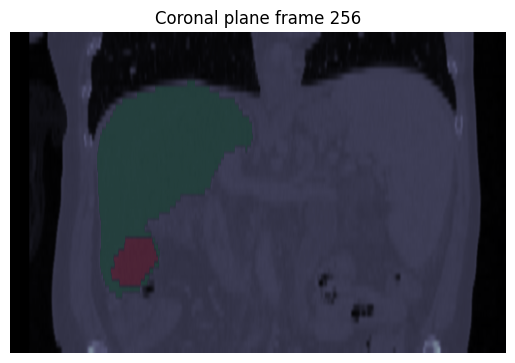

Animation saved on ../results/reference_coronal_plane_seg.gif


In [30]:
make_coronal_plane_with_seg_gif(reference_img, tumor_mask, liver_mask, "reference_coronal_plane_seg.gif")

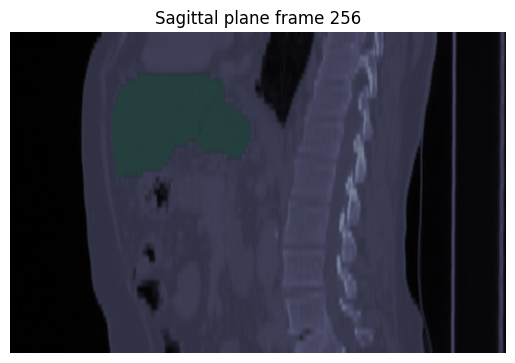

Animation saved on ../results/reference_sagittal_plane_seg.gif


In [31]:
make_sagittal_plane_with_seg_gif(reference_img, tumor_mask, liver_mask, "reference_sagittal_plane_seg.gif")

Finally, we can visualize the image as a coronal-sagittal rotation which also includes the bounding box of the tumor mask.

GIF saved at ../results/MIP_seg/reference_coronal-sagittal_rotation_seg.gif


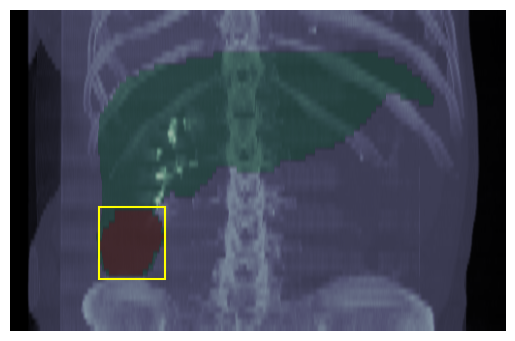

In [32]:
coronal_sagittal_seg_rotation(
    reference_img,
    tumor_mask,
    liver_mask,
    "reference_coronal-sagittal_rotation_seg.gif")